# Comparison between learning sensorimotor models 
## Part 1 : non parametric models

In this notebook, we compare the different sensorimotor models used in explauto in order to help the reader to use the most appropriate model depending on his aim. The notebook is split in two parts : non parametrics models (this notebook) and models based on gaussian mixtures (coming soon). There is also a tutorial explaining how to use the [SensorimotorModel abstract class](http://flowersteam.github.io/explauto/explauto.sensorimotormodel.html#explauto.sensorimotor_model.sensorimotor_model.SensorimotorModel) ([learning_sensorimotor_models](http://nbviewer.ipython.org/github/flowersteam/explauto/blob/master/notebook/learning_sensorimotor_models.ipynb)).

As explained in the [Explauto introduction](http://flowersteam.github.io/explauto/about.html), an important challenge in Developmental Robotics is how robots can efficiently learn sensorimotor mappings by experience, i.e. the mappings between the motor actions they make and the sensory effects they produce. This can be a robot learning how arm movements make physical objects move, or how movements of a virtual vocal tract modulates vocalization sounds.

### Sensorimotor models introduction

In Explauto, a sensorimotor model implements both the iterative learning process from sensorimotor experience, i.e. from the iterative collection of $(m, s)$ pairs by interaction with the environment, and the use of the resulting internal model to perform forward and inverse predictions (or any kind of general prediction between sensorimotor subspaces). 

Learning sensorimotor mappings involves machine learning algorithms, for which Explauto provides a unified interface through the [SensorimotorModel abstract class](http://flowersteam.github.io/explauto/explauto.sensorimotormodel.html#explauto.sensorimotor_model.sensorimotor_model.SensorimotorModel). 

Using the simple arm environment above, it allows to iteratively learn a sensorimotor model which will be able to:
* infer the position of the end-effector from a given motor command, what is called *forward prediction*,
* infer the motor command allowing to reach a particular end-effector position, what is called *inverse prediction*.
* update online from sensorimotor experience

In [2]:
from scipy import spatial
import numpy as np
import time

#Environment definition
from explauto.environment.environment import Environment
environment = Environment.from_configuration('simple_arm', 'mid_dimensional')

from explauto import SensorimotorModel
from explauto.sensorimotor_model import sensorimotor_models
from explauto.utils import rand_bounds

### Non parametric or gaussian mixture models ? 

Each of non parametric model is currently based on the nearest neigbhor look up. They are non paramtric models because they don't rely on assomptions that the data are drown from a given probability while gassian mixture models (GMM) assumes that the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. Readers in this case should refer to the follwing tutorial : *coming soon* .

Available sensorimotor models in Explauto can be accessed using: 

In [3]:
print 'Available sensorimotor models: {}'.format(sensorimotor_models.keys())

Available sensorimotor models: ['LWLR-BFGS', 'nearest_neighbor', 'WNN', 'LWLR-CMAES']


### Presentation of the different non parametric models

These 4 non parametric models, which are a combination of a forward and an inverse model, are:
* the **nearest neighbor** model searches the nearest point of a given input ($m$ or $s$) in the dataset and returns its corresponding value (respectively $s$ or $m$)
* the **WNN or weighted nearest neighbor** model searches the $k$ nearest points of a given input ($m$ or $s$) in the dataset and returns the average of the $k$ corresponding values (respectively $m$ or $s$)
* Both **LWLR-BFGS and LWLR-CMAES** use **the Locally Weigthed Linear Regression (LWLR)** for their forward models. It computes a linear regression of the $k$ nearest neighbors of $m$ and find the requested $s$ with the given $m$ based on that regression. Both inverse models are optimisation algorithm that minimize the error  $e(m) = ||LWLR(m) - s_g||^2$  where $s_g$ is the goal, $LWLR$ is the forward model LWLR, and $m$ is the motor command to be infered. BFGS and CMAES are inverse models which are going to be explained later.

### Creating models or changing their caracteristics (k, sigma, ...)

Then, it is possible to change its caracteristics like sigma exploration ratio for nearest neighbor models or the number $k$ of nearest neighbor in WNN models and so on. For instance, in order to create a model using LWLR forward model and Cobyla as inverse model : 

In [64]:
from explauto.sensorimotor_model.non_parametric import NonParametric
custom_config = {'fwd': 'LWLR', 'inv': 'COBYLA', 'k': 10, 'maxfun' : 50}
sensorimotor_models['LWLR-COBYLA'] = {}
sensorimotor_models['LWLR-COBYLA'] = (NonParametric, {'default' : custom_config})

Whether changes are made or not, in order to know the caracteristics of the different models:

In [5]:
sm_cls, sm_configs = sensorimotor_models['nearest_neighbor']
# or 'WNN', 'LWLR-BFGS', 'LWLR-CAMES', 'LWLR-COBYLA' (if the previous lines have been executed)
model = sm_cls(environment.conf, **sm_configs['default'])

### Eploit or explore mode ?

All the non-parametric sensorimotor models have two operating modes: "explore" and "exploit".

In the "explore" mode, when the agent asks for the exact inverse prediction $m$ of a goal $s_g$, $m$ will be perturbated with some gaussian exploration noise in order to allow the agent to explore new motor commands. The sensorimotor models thus have a common parameter: sigma_explo_ratio=0.1 (default), which is the standard deviation of the gaussian noise, scaled depending of the motor domain size: if a motor value is bounded in [-2:2], then a sigma_explo_ratio of 0.1 will induce an exploration noise of (m_max - m_min) * sigma_explo_ratio = 0.4

In the "exploit" mode, no exploration noise is added. This mode is used for instance when evaluating the inverse model for comparison purposes.

The default mode is explore, in order to switch to exploit mode:

In [14]:
model.mode = 'exploit'

### Forward and inverse model distinction

The forward model uses the dataset for the forward prediction computation, and the inverse model uses the forward model, or directly the dataset to perform inverse prediction. In other words, forward models predict $s_p$ given a $m$ that might have never been observed, using the dataset of observations $(m,s)$ and inverse models infer a motor command $m$ that should be able to reach a given goal $s_g$.  

For each of these models it is necessary to load the mode with the appropriate model chosen as explained earlier and then create a dataset of n $(m,s)$ couples which is going to be tested later.

In [ ]:
#Creation of the dataset
def generateFwdDataset(_environment, _model, _n = 10000):
    random_motors = _environment.random_motors(n=_n)
   
    for m in random_motors:
        s = _environment.compute_sensori_effect(m)
        _model.update(m, s)

In [74]:
    
# Distance between the predictive and effectiv value
    
def generateFwdTest(_environment, _model, _n = 100):
    #Test of the model
    %pylab inline
    test = _environment.random_motors(n=_n)
    distance = []
    timer = []
    
 
    for mTest in test :
        start = time.time()
        sTest_pred = _model.forward_prediction(mTest)
        end = time.time()
        sTest_eff = _environment.compute_sensori_effect(mTest)
        distance.append(spatial.distance.pdist([sTest_pred,sTest_eff])[0])
        timer.append(end - start)
        figure(1)
        plot(sTest_pred[0], sTest_eff[0], 'ok')
        figure(2)
        plot(sTest_pred[0], sTest_pred[1], 'or')
        plot(sTest_eff[0], sTest_eff[1], 'ob')
        plot([sTest_pred[0], sTest_eff[0]], [sTest_pred[1], sTest_eff[1]], '-g')
     
    figure(1)
    axis([0,1,0,1])
    plot([0,1], [0,1], 'r-', lw=2)
    title("Fwd - Comparison between x of s effective and predicted")
    xlabel("x predicted")
    ylabel("x effective")
    
    figure(2)
    title("Fwd - Distance between effective and predicted")
    xlabel("x")
    xlabel("y")
    
    return {'mean distance' : np.mean(distance), 'std distance': np.std(distance) ,'max distance' : max(distance),
            'mean time': np.mean(timer), 'std time': np.std(timer), 'max time': max(timer)}

In [80]:
 # Distance between the predictive and effectiv value
    
def generateInvTest(_environment, _model, _n = 100):
    #Test of the model
    %pylab inline
    test_cases = rand_bounds(np.array([[0,0], [1,1]]), n=_n)
    distance = []
    timer = []
    
    for sTest_goal in test_cases :
        start = time.time()
        mTest = _model.inverse_prediction(sTest_goal)
        end = time.time()
        sTest_eff = _environment.compute_sensori_effect(mTest)
        distance.append(spatial.distance.pdist([sTest_goal,sTest_eff])[0])
        timer.append(end - start)
        figure(1)
        plot(sTest_goal[0], sTest_eff[0], 'ok')
        figure(2)
        plot(sTest_goal[0], sTest_goal[1], 'or')
        plot(sTest_eff[0], sTest_eff[1], 'ob')
        plot([sTest_goal[0], sTest_eff[0]], [sTest_goal[1], sTest_eff[1]], '-g')
      
    figure(1)
    axis([0,1,0,1])
    plot([0,1], [0,1], 'r-', lw=2)
    title("Inv - Comparison between x of s effective and predicted")
    xlabel("x goal")
    ylabel("x effective")
    
        
    figure(2)
    title("Fwd - Distance between effective and predicted")
    xlabel("x")
    xlabel("y")
    
    return {'mean distance' : np.mean(distance), 'std distance': np.std(distance) ,'max distance' : max(distance),
            'mean time': np.mean(timer), 'std time': np.std(timer), 'max time': max(timer)}

### Getting started with forward models

The predicted sensorimotor effect $s_p$ of a command $m$ depending on a given model can be obtained this way after defining the model: 

In [ ]:
s_pred = model.forward_prediction(m)

In order to test foward models, we are going to generate randomly n $m$ and use one of these models to find out $s_p$. The distance between $s_g$ and the real s plus the time processing are saved in $fwd _ model$ dictionary. 

#### Nearest Neighbor forward model

To perform a forward prediction, the Nearest Neighbor model looks in the dataset of tuples $(m, s)$ for the nearest neighbor of the given $m$ motor command, and returns its corresponding $s$.
The algorithm comes from scipy library : [scipy.spatial.KDTree.query](http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.spatial.KDTree.query.html) (with x = $s$, k=1, eps = 0, p = 2, radius = +inf). It returns distance of found nearest neighbors $s_p$.

Let's see how to use it : 

Populating the interactive namespace from numpy and matplotlib


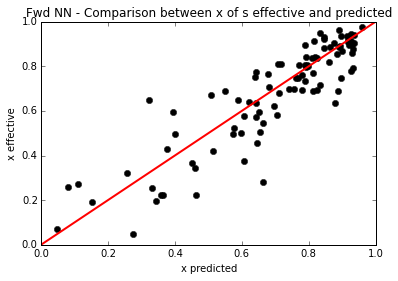

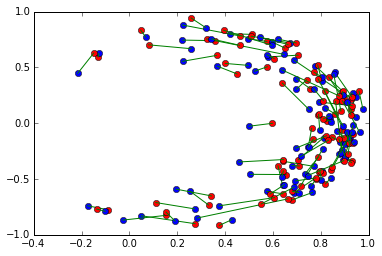

In [73]:
sm_cls, sm_configs = sensorimotor_models['nearest_neighbor']
modelNN = sm_cls(environment.conf, **sm_configs['default'])
generateFwdDataset(environment, modelNN)
fwd_NN = generateFwdTest(environment, modelNN)

#### Weighted Nearest Neighbor forward model

To perform a forward prediction of $m$, the Weighted Nearest Neighbor model looks for the $k$ (parameter) nearest neighbors of $m$ in the dataset, and returns the average of the $k$ corresponding $s$. This average is weighted by the distance to $m$ with a gaussian of standard deviation $\sigma$ (parameter). It finds the $k$ nearest neighbors (with the same algorithm than for NN model :[scipy.spatial.KDTree.query](http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.spatial.KDTree.query.html), with k = n the number of interesting neigbhors )  before weights them. It returns the n-dimensional weighted neighbor $s_p$. 

Populating the interactive namespace from numpy and matplotlib


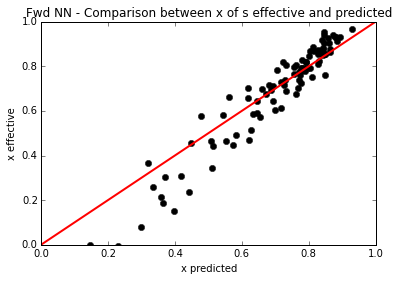

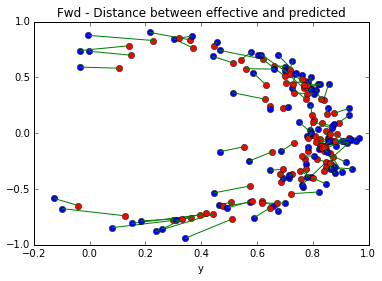

In [77]:
sm_cls, sm_configs = sensorimotor_models['WNN']
modelWNN = sm_cls(environment.conf, **sm_configs['default'])
generateFwdDataset(environment, modelWNN)
fwd_WNN = generateFwdTest(environment, modelWNN)

####Locally Weighted Linear Regression forward model

The LWLR computes a linear regression of the $k$ nearest neighbors of $m$ which is weighted by the distances from $m$ to his neighbors. It finds the requested $s_p$ given $m$. As before, it is possible to change the number $k$ of nearest neighbors. 

Populating the interactive namespace from numpy and matplotlib


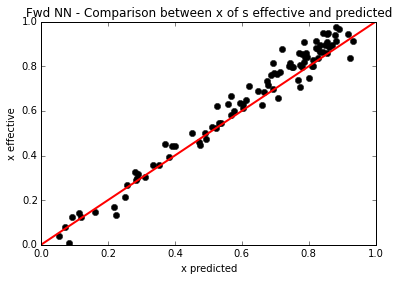

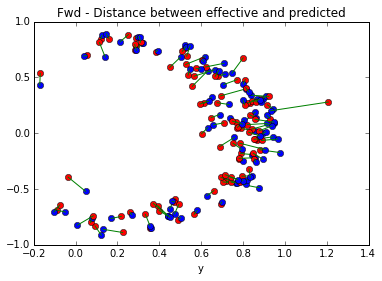

In [78]:
sm_cls, sm_configs = sensorimotor_models['LWLR-BFGS']
modelLWLR = sm_cls(environment.conf, **sm_configs['default'])
generateFwdDataset(environment, modelLWLR)
fwd_LWLR = generateFwdTest(environment, modelLWLR)

### Forward models comparisons

In [37]:
print fwd_NN, '\n', fwd_WNN, '\n', fwd_LWLR, '\n'

{'max time': 0.011260986328125, 'mean time': 0.00037045001983642577, 'mean distance': 0.16072982253082238, 'max distance': 0.43973074597217354, 'std time': 0.0010947639700226491, 'std distance': 0.10037534368797667} 
{'max time': 0.011703968048095703, 'mean time': 0.00073633909225463863, 'mean distance': 0.093771696344595853, 'max distance': 0.30806254447231185, 'std time': 0.0011039698586537453, 'std distance': 0.058426547119284841} 
{'max time': 0.012078046798706055, 'mean time': 0.00098849296569824218, 'mean distance': 0.085331665126708686, 'max distance': 0.5727275322273625, 'std time': 0.0011153885287879712, 'std distance': 0.086142758938267172} 



#### Distance between $s_p$ and $s$ comparison

If we look at comparisons values with a 1000 training $(m,s)$, we can easily notice that LWLR is closer to the goal on average than NN or WNN model. NN is really further than the two others which are not so different and the 3 standard deviation is equivalent. And the maximum distance can be sometimes very far away between the prediction and the goal for NN models. With a bigger dataset (10000), NN gets better results and is closest to the two other models even if they are still better. LWLR has still the best average but WNN has a significant better standard deviation and a smallest maximum distance. To conclude, LWLR looks better in average but seems to be less good sometimes than the WNN model for an equal number k of neighbors. 

#### Time processing comparison

NN model is far away faster than WNN and LWLR in speed processing in any case : around 4 times faster than LWLR model and twice faster than WNN with an equal standard deviation for $n$ = 100. These results were forseeable knowing that LWLR also computes WNN to make its model and WNN uses NN search. These models work sufficiently well in different typical robotic applications but can be very long if the dataset's size exceed $10⁵$. In that case, it would be faster to use an approximate nearest neighbor search. The processing time can be accelerated for WNN and LWLR by reducing the number of $k$ neighbors observed but it would also alterate the distance results.

### Getting started with inverse models

The predicted motor command $m_p$ to reach a goal $s_g$ can be obtained this way :

In [ ]:
m_pred = model.inverse_prediction(s_g)

In order to test foward models, we are going to generate randomly n $s_g$ and use one of these models to find out $m$. The distance between $s_g$ and the effective $s$ and the time processing are weighted and saved in $comparison$ dictionary.

####Nearest Neighbor inverse model


To perform the inverse inference, the Nearest Neighbor inverse model looks in the dataset of tuples $(m, s)$, the nearest neighbor of the given $s$ motor command, and return its corresponding $m$. 

Populating the interactive namespace from numpy and matplotlib


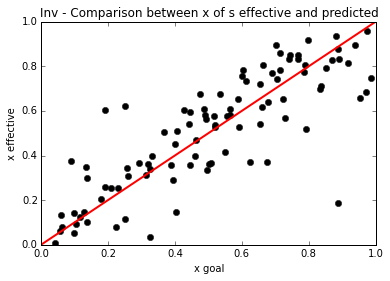

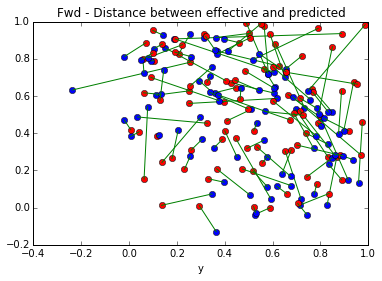

In [81]:
sm_cls, sm_configs = sensorimotor_models['nearest_neighbor']
modelNN = sm_cls(environment.conf, **sm_configs['default'])
generateFwdDataset(environment, modelNN)
inv_NN = generateInvTest(environment, modelNN)

####  WNN Inverse Model

Typical robotic forward models are very redundant: e.g. a robotic arm can put its hand to position $s$ with an infinity of possible $m$ motor positions.
Thus, trying to infer a motor command $m$ to reach a given goal $s$ doing an average of the nearest neighbors of $s$ in the dataset would make no sense as those nearest neighbors might have very different corresponding motor commands.
But to perform the inverse inference of a given $s$, the Weighted Nearest Neighbor model looks at the nearest neighbor of $s$ in the dataset and gets its corresponding $m$. It finds now the $k$ nearest neighbors of $m$ in the dataset, and returns their average weighted by the distance of their sensory part to $s$, with a gaussian of standard deviation $\sigma$ (parameter).

Populating the interactive namespace from numpy and matplotlib


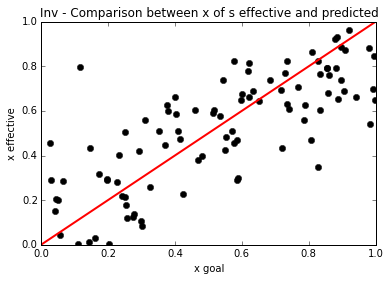

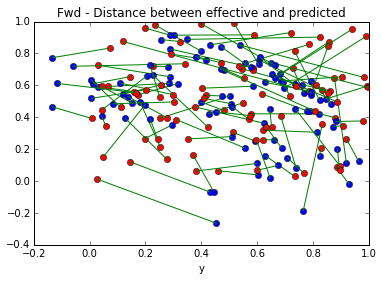

In [82]:
sm_cls, sm_configs = sensorimotor_models['WNN']
modelWNN = sm_cls(environment.conf, **sm_configs['default'])
generateFwdDataset(environment, modelWNN)
inv_WNN = generateInvTest(environment, modelWNN)

####Optimization Inverse Model (BFGS and CMAES)
Another possibility to perform inverse inference is to use an optimization algorithm to minimize the error  $e(m) = ||f(m) - s_g||^2$  where $s_g$ is the goal, $f$ is the forward model, and $m$ is the motor command to be infered.

This is how our [scipy.optimize based](https://github.com/flowersteam/explauto/blob/master/explauto/sensorimotor_model/inverse/sciopt.py#L8) inverse models do. They take a 'maxfun' ([BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm)) or 'maxiter' ([COBYLA](https://en.wikipedia.org/wiki/COBYLA)) parameter that limits the number of error function (and so forward model) evaluation. These two algorithms are efficient to find local minima bacause they work with second order derivates.

The Covariance Matrix Adaptation -Evolutuionary Strategy (**CMAES**) optimizes that error function by making fewer assumptions on the regularity of the forward model to perform the search. It is based on a random exploration (with a computed covariance) around a current point of interest, and adapts this point and recompute the covariance matrix at each iteration, with memory of the taken path.
The initial point is set as the motor part $m$ of the nearest neighbor $s$ of the goal $s_g$, and the initial covariance matrix is identity times an exploration $\sigma$ (parameter). This inverse model also takes a 'maxfevals' parameter that limits the number of forward model evaluations.

The method should be applied, if BFGS fails due to a rugged search landscape (e.g. discontinuities, sharp bends or ridges, noise, local optima, outliers). If second order derivative based methods are successful, they are usually faster than the CMA-ES: on purely convex-quadratic functions, BFGS is typically faster by a factor of about ten (in terms of number of objective function evaluations needed to reach a target function value, assuming that gradients are not available). 

See [Hansen's website](https://www.lri.fr/~hansen/cmaesintro.html) and this [tutorial](https://www.lri.fr/~hansen/cmatutorial.pdf) on CMA-ES.

Populating the interactive namespace from numpy and matplotlib


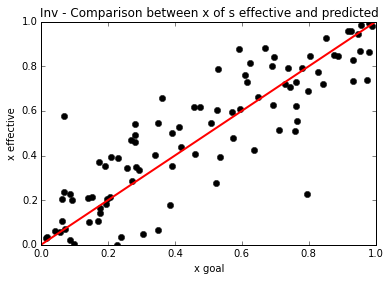

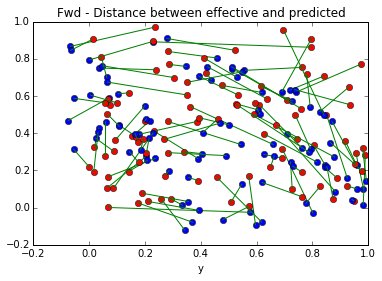

In [83]:
sm_cls, sm_configs = sensorimotor_models['LWLR-BFGS']
modelBFGS = sm_cls(environment.conf, **sm_configs['default'])
generateFwdDataset(environment, modelBFGS)
inv_BFGS = generateInvTest(environment, modelBFGS)

(<class 'explauto.sensorimotor_model.non_parametric.NonParametric'>, {'default': {'fwd': 'LWLR', 'k': 10, 'inv': 'L-BFGS-B', 'maxfun': 50}})
Populating the interactive namespace from numpy and matplotlib


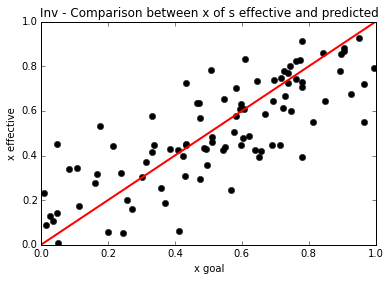

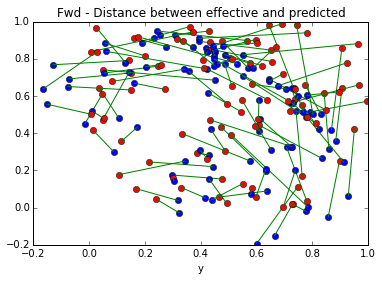

In [84]:

print sensorimotor_models['LWLR-BFGS']
sm_cls, sm_configs = sensorimotor_models['LWLR-COBYLA']
modelCOBYLA = sm_cls(environment.conf, **sm_configs['default'])
generateFwdDataset(environment, modelCOBYLA)
inv_COBYLA = generateInvTest(environment, modelCOBYLA)

Populating the interactive namespace from numpy and matplotlib


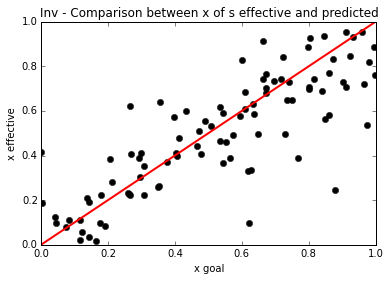

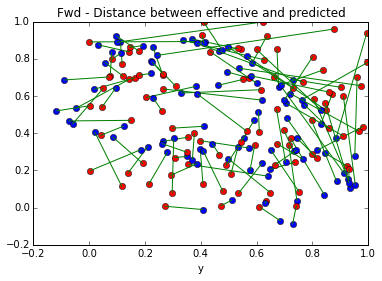

In [85]:
sm_cls, sm_configs = sensorimotor_models['LWLR-CMAES']
modelCMA = sm_cls(environment.conf, **sm_configs['default'])
generateFwdDataset(environment, modelCMA)
inv_CMA = generateInvTest(environment, modelCMA)

### Inverse models comparisons

In [69]:
print inv_NN, '\n', inv_WNN, '\n', inv_BFGS, '\n', inv_COBYLA, '\n', inv_CMA

{'max time': 0.010724067687988281, 'mean time': 0.00041047811508178713, 'mean distance': 0.20168292159661327, 'max distance': 0.59686369464621802, 'std time': 0.0010366151892852594, 'std distance': 0.13705465684012169} 
{'max time': 0.033882856369018555, 'mean time': 0.012726972103118897, 'mean distance': 0.23639504162074204, 'max distance': 0.76669268165169346, 'std time': 0.0022641205855169206, 'std distance': 0.14802255009520515} 
{'max time': 0.06476306915283203, 'mean time': 0.037118465900421144, 'mean distance': 0.18990682784894602, 'max distance': 0.67562787551620396, 'std time': 0.010865131486743193, 'std distance': 0.12664684144794416} 
{'max time': 0.07274603843688965, 'mean time': 0.022376320362091064, 'mean distance': 0.2002982591788359, 'max distance': 0.60823034408229959, 'std time': 0.0094409313074482956, 'std distance': 0.12922653395158204} 
{'max time': 0.2664639949798584, 'mean time': 0.14175652027130126, 'mean distance': 0.19038157825142649, 'max distance': 0.6294403

#### Distance between $s_p$ and $s$ comparison
The mean distance is almost the same for each method knowing that the training set has 10000 $m,s$ pairs and that we test 100 points. With others parameters, CMAES could have better results.

#### Time processing comparison
NN is the fastest inverse method and is used to find the first point in BFGS, COBYLA, CMAES and GMR look up. CMAES is almost 4 times slower than Cobyla and BFGS and 10 times slower than WNN to compute the distance (for $n$ = 100 observations). 